In [1]:
# PyDESeq2 Workflow: Differential Expression
# Soybean at 7_dpi (day 7: post innoculation)

In [2]:
## Import Necessary Libraries

In [3]:
import os
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from adjustText import adjust_text

from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats

In [4]:
import warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
## Load Data

In [6]:
df = pd.read_csv('combined_reads_soybean_dpi7.csv')
df.head()

,Geneid,Alternaria_T7_1,Alternaria_T7_2,Alternaria_T7_3,Alternaria_T7_4,Control_T7_1,Control_T7_2,Control_T7_3,Control_T7_4
0,GLYMA_18G079000,46,45,75,15,22,26,37,21
1,GLYMA_18G080300,1268,1383,1818,877,1581,1014,1322,1629
2,GLYMA_18G224800,0,1,0,6,23,2,22,10
3,GLYMA_18G197600,4023,4141,3724,2392,2190,2878,2160,2948
4,GLYMA_18G079400,2209,2378,2491,1341,1973,1884,1778,2131


In [7]:
# set Geneid as index
data = df.set_index('Geneid')
data.head(2)

,Alternaria_T7_1,Alternaria_T7_2,Alternaria_T7_3,Alternaria_T7_4,Control_T7_1,Control_T7_2,Control_T7_3,Control_T7_4
Geneid,,,,,,,,
GLYMA_18G079000,46,45,75,15,22,26,37,21
GLYMA_18G080300,1268,1383,1818,877,1581,1014,1322,1629


In [8]:
# filter out genes and keep rows where the sum is greater than 10; then transpose
data = data[data.sum(axis = 1) > 10].T 
data

Geneid,GLYMA_18G079000,GLYMA_18G080300,GLYMA_18G224800,GLYMA_18G197600,GLYMA_18G079400,GLYMA_18G003000,GLYMA_18G291100,GLYMA_18G058900,GLYMA_18G145000,GLYMA_18G231300,...,GLYMA_U005500,GLYMA_U005400,GLYMA_U005800,GLYMA_U007300,GLYMA_U007200,GLYMA_U009100,GLYMA_U009000,GLYMA_U007000,GLYMA_U008200,GLYMA_U022500
Alternaria_T7_1,46,1268,0,4023,2209,637,918,6214,235,782,...,63,23,30,5,20,29,9,4202,6,581
Alternaria_T7_2,45,1383,1,4141,2378,796,920,7567,276,1053,...,36,43,26,6,17,65,11,3988,5,706
Alternaria_T7_3,75,1818,0,3724,2491,872,930,6737,161,1152,...,34,30,35,16,20,48,5,4867,8,612
Alternaria_T7_4,15,877,6,2392,1341,431,568,3891,107,937,...,36,21,11,5,7,49,18,2820,0,298
Control_T7_1,22,1581,23,2190,1973,886,638,7448,179,242,...,68,14,34,11,7,44,18,1152,6,684
Control_T7_2,26,1014,2,2878,1884,764,595,7005,450,373,...,41,4,47,17,57,81,32,845,10,859
Control_T7_3,37,1322,22,2160,1778,968,651,6814,249,459,...,20,12,19,12,26,49,21,1089,11,444
Control_T7_4,21,1629,10,2948,2131,1182,635,7417,212,292,...,43,14,41,7,36,80,6,941,12,426


In [9]:
# Create Metadata

In [10]:
samples = data.index.tolist()

In [11]:
metadata = pd.DataFrame({
    'Sample': samples,
    'condition': ['Treatment'] * 4 + ['Control'] * 4,
    'group': ['X', 'Y', 'X', 'Y', 'X', 'Y', 'X', 'Y']
})

metadata.set_index('Sample', inplace=True)

In [12]:
metadata

,condition,group
Sample,,
Alternaria_T7_1,Treatment,X
Alternaria_T7_2,Treatment,Y
Alternaria_T7_3,Treatment,X
Alternaria_T7_4,Treatment,Y
Control_T7_1,Control,X
Control_T7_2,Control,Y
Control_T7_3,Control,X
Control_T7_4,Control,Y


In [13]:
# Single Factor Analysis

In [14]:
# Initialize the DESeq2 dataset using the DeseqDataSet class
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=data,
    metadata=metadata,
    design_factors="condition",
    refit_cooks=True,
    inference=inference,
)

In [15]:
dds

AnnData object with n_obs × n_vars = 8 × 42504
    obs: 'condition', 'group'
    obsm: 'design_matrix'

In [16]:
dds.obs

,condition,group
Sample,,
Alternaria_T7_1,Treatment,X
Alternaria_T7_2,Treatment,Y
Alternaria_T7_3,Treatment,X
Alternaria_T7_4,Treatment,Y
Control_T7_1,Control,X
Control_T7_2,Control,Y
Control_T7_3,Control,X
Control_T7_4,Control,Y


In [17]:
dds.var

""
Geneid
GLYMA_18G079000
GLYMA_18G080300
GLYMA_18G224800
GLYMA_18G197600
GLYMA_18G079400
...
GLYMA_U009100
GLYMA_U009000
GLYMA_U007000


In [18]:
dds.X

array([[  46, 1268,    0, ..., 4202,    6,  581],
       [  45, 1383,    1, ..., 3988,    5,  706],
       [  75, 1818,    0, ..., 4867,    8,  612],
       ...,
       [  26, 1014,    2, ...,  845,   10,  859],
       [  37, 1322,   22, ..., 1089,   11,  444],
       [  21, 1629,   10, ...,  941,   12,  426]])

In [19]:
dds.X.shape

(8, 42504)

In [20]:
# run deseq2 analysis
dds.deseq2()

Fitting size factors...
... done in 0.03 seconds.

Fitting dispersions...
... done in 101.20 seconds.

Fitting dispersion trend curve...
... done in 5.03 seconds.

Fitting MAP dispersions...
... done in 124.73 seconds.

Fitting LFCs...
... done in 58.62 seconds.

Refitting 0 outliers.



In [21]:
dds

AnnData object with n_obs × n_vars = 8 × 42504
    obs: 'condition', 'group'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'

In [22]:
# Dispersions and LFCs (in natural log scale)
dds.varm["dispersions"]

array([0.14784155, 0.03038811, 1.45351348, ..., 0.02161724, 0.39687504,
       0.05973615])

In [23]:
dds.varm["LFC"]

,intercept,condition_Treatment_vs_Control
Geneid,,
GLYMA_18G079000,3.341601,0.328122
GLYMA_18G080300,7.290329,-0.191836
GLYMA_18G224800,2.727264,-1.998034
GLYMA_18G197600,7.895661,0.189980
GLYMA_18G079400,7.627488,-0.076325
...,...,...
GLYMA_U009100,4.202942,-0.394418
GLYMA_U009000,3.026101,-0.627583
GLYMA_U007000,6.975272,1.222365


In [24]:
# Principal Component Analysis (PCA)

In [25]:
# Log-transform the counts
log_transformed = np.log2(data + 1)

In [26]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(log_transformed)

In [27]:
# Create a DataFrame with PCA results and metadata
pca_df = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])
pca_df['condition'] = metadata['condition'].values

In [28]:
# Calculate explained variance for the plot
explained_variance = pca.explained_variance_ratio_

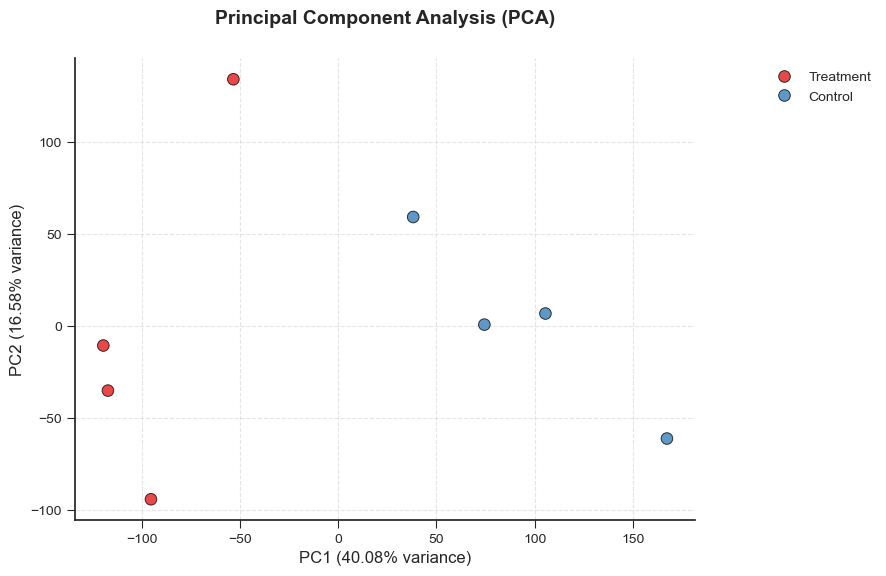

In [29]:
# Set a clean and professional style
plt.style.use('seaborn-ticks')

# Create PCA plot
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    x='PC1', y='PC2', hue='condition', data=pca_df, 
    s=70, edgecolor='black', alpha=0.8, palette='Set1'
)

# Label axes with explained variance
plt.xlabel(f'PC1 ({explained_variance[0] * 100:.2f}% variance)', fontsize=12)
plt.ylabel(f'PC2 ({explained_variance[1] * 100:.2f}% variance)', fontsize=12)

# Title and legend improvements
plt.title('Principal Component Analysis (PCA)', fontsize=14, weight='bold', pad=25)
plt.legend(title='', bbox_to_anchor=(1.1, 1), loc='upper left', fontsize=10)

# Improve visual clarity
plt.grid(True, linestyle='--', alpha=0.5)
sns.despine()  # Removes unnecessary borders

# Save figure in high resolution
plt.savefig('PCA_soybean_7dpi.png', dpi=600, bbox_inches='tight')
plt.show()

In [30]:
# Statistical Analysis with the DeseqStats class

In [31]:
stat_res = DeseqStats(dds, inference=inference)

In [32]:
# Wald Test
stat_res.summary()

Running Wald tests...
... done in 17.20 seconds.



Log2 fold change & Wald test p-value: condition Treatment vs Control
                    baseMean  log2FoldChange     lfcSE       stat  \
Geneid                                                              
GLYMA_18G079000    33.592181        0.473380  0.431212   1.097791   
GLYMA_18G080300  1338.070384       -0.276761  0.180032  -1.537289   
GLYMA_18G224800     8.787952       -2.882553  1.336108  -2.157426   
GLYMA_18G197600  2966.584836        0.274083  0.125997   2.175307   
GLYMA_18G079400  1978.006794       -0.110114  0.072185  -1.525441   
...                      ...             ...       ...        ...   
GLYMA_U009100      56.176095       -0.569024  0.384676  -1.479230   
GLYMA_U009000      15.983391       -0.905411  0.733438  -1.234475   
GLYMA_U007000    2351.460130        1.763500  0.152149  11.590589   
GLYMA_U008200       7.088634       -1.345894  0.765775  -1.757559   
GLYMA_U022500     564.532592       -0.389760  0.253070  -1.540128   

                       pvalue    

In [33]:
# Expressed genes
res = stat_res.results_df
res.head(5)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Geneid,,,,,,
GLYMA_18G079000,33.592181,0.473380,0.431212,1.097791,0.272296,0.412282
GLYMA_18G080300,1338.070384,-0.276761,0.180032,-1.537289,0.124223,0.227362
GLYMA_18G224800,8.787952,-2.882553,1.336108,-2.157426,0.030972,0.075380
GLYMA_18G197600,2966.584836,0.274083,0.125997,2.175307,0.029607,0.072537
GLYMA_18G079400,1978.006794,-0.110114,0.072185,-1.525441,0.127149,0.231710


In [34]:
# Filter 'res' to identify significantly expressed genes
sigs = res[(res.padj < 0.01) & (abs(res.log2FoldChange) > 1.5)]
sigs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Geneid,,,,,,
GLYMA_18G022100,34.753378,-2.905014,0.778678,-3.730700,1.909482e-04,9.902087e-04
GLYMA_18G255000,733.863869,1.737259,0.182213,9.534225,1.510086e-21,1.077573e-19
GLYMA_18G116700,143.099985,1.964024,0.281451,6.978200,2.989854e-12,6.646889e-11
GLYMA_18G071900,6488.175187,-1.661676,0.197524,-8.412545,4.012086e-17,1.664241e-15
GLYMA_18G223000,104.818955,1.825043,0.402087,4.538919,5.654333e-06,4.309859e-05
...,...,...,...,...,...,...
GLYMA_U042800,13.558131,-1.815223,0.586805,-3.093403,1.978755e-03,7.534219e-03
GLYMA_U022200,43.917581,-2.023328,0.551865,-3.666347,2.460398e-04,1.235101e-03
GLYMA_U032900,49.680644,3.543922,0.867536,4.085045,4.406834e-05,2.711801e-04


In [35]:
dds

AnnData object with n_obs × n_vars = 8 × 42504
    obs: 'condition', 'group'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks'

In [36]:
#calculate the natural logarithm of the normalized expression values
dds.layers['normed_counts']
dds.layers['log1p'] = np.log1p(dds.layers['normed_counts'])
dds.layers['log1p']

array([[3.70368563, 6.99621509, 0.        , ..., 8.19369551, 1.81885259,
        6.21685147],
       [3.5887906 , 6.98704198, 0.57773983, ..., 8.04547318, 1.5912803 ,
        6.31553232],
       [4.10900009, 7.28113233, 0.        , ..., 8.26544172, 1.99983262,
        6.19372799],
       ...,
       [3.35258947, 6.98145993, 1.13824309, ..., 6.79932415, 2.45155655,
        6.81573828],
       [3.74269719, 7.29538395, 3.23884503, ..., 7.10164325, 2.58415784,
        6.20564864],
       [3.08863688, 7.39381657, 2.39560438, ..., 6.84548768, 2.56262318,
        6.05426965]])

In [37]:
dds_sigs = dds[:, sigs.index]
dds_sigs

View of AnnData object with n_obs × n_vars = 8 × 2531
    obs: 'condition', 'group'
    uns: 'trend_coeffs', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', 'replaceable'
    varm: 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', '_normed_means', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced'
    layers: 'normed_counts', '_mu_hat', '_mu_LFC', '_hat_diagonals', 'cooks', 'log1p'

In [38]:
# Heatmap

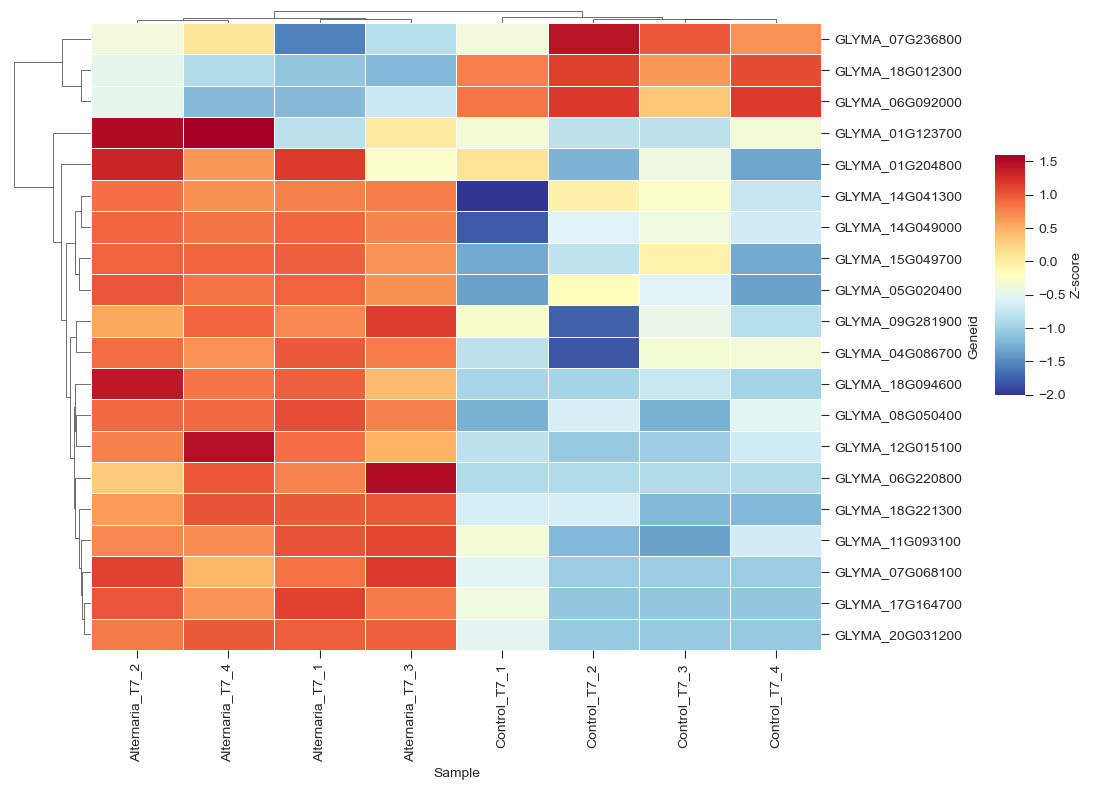

In [39]:
# Create a DataFrame from the log-transformed expression matrix
grapher = pd.DataFrame(dds_sigs.layers['log1p'].T,
                       index=dds_sigs.var_names, columns=dds_sigs.obs_names)

# Select the top 20 most variable genes based on standard deviation
top_genes = grapher.var(axis=1).nlargest(20).index
grapher_top = grapher.loc[top_genes]

# Create a hierarchical clustering heatmap with an aligned color bar
g = sns.clustermap(grapher_top, z_score=0, cmap='RdYlBu_r', figsize=(10, 8),
                   linewidths=0.5, xticklabels=True, yticklabels=True,
                   cbar_pos=(1, 0.5, 0.03, 0.3),  # Aligns color bar to the right
                   dendrogram_ratio=(0.1, 0.02),  # Adjusts dendrogram proportions
                   cbar_kws={'label': 'Z-score'})  # Labels the color bar

plt.savefig('Heatmap_soybean_7dpi.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

In [40]:
# Volcano plot

In [41]:
# Define significance thresholds
padj_threshold = 0.01
logFC_threshold = 1.5

In [42]:
# Filter significant results and split
significant_sigs = res[(res['padj'] < padj_threshold) & (abs(res['log2FoldChange']) > logFC_threshold)]
positive_sigs = significant_sigs[significant_sigs['log2FoldChange'] > 0]
negative_sigs = significant_sigs[significant_sigs['log2FoldChange'] < 0]

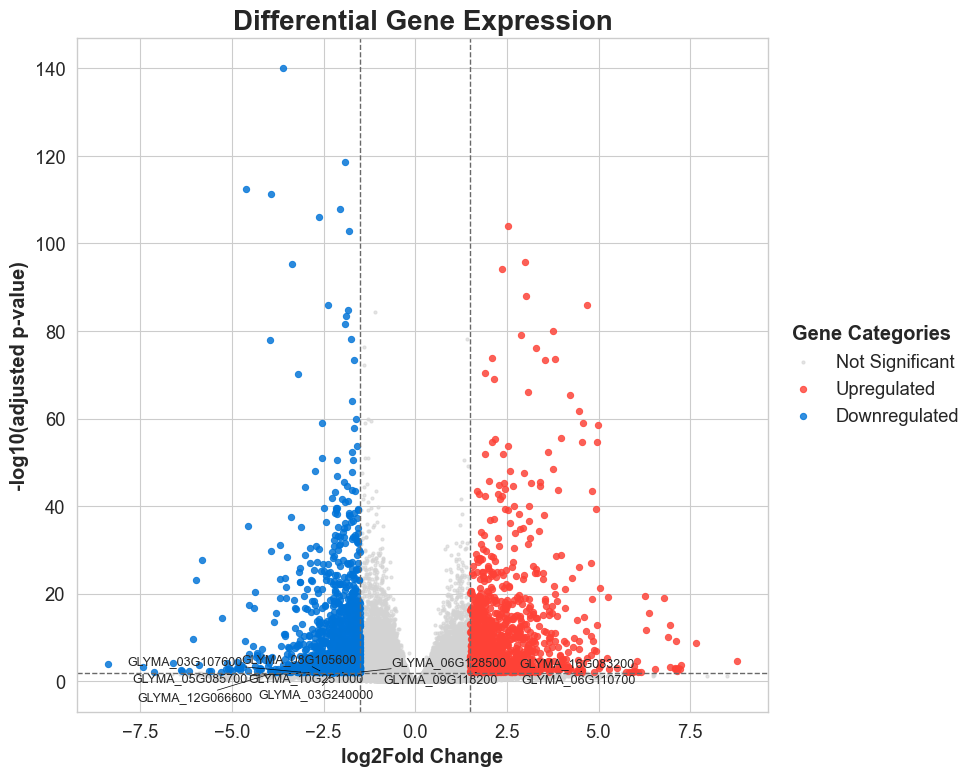

In [43]:
# Set up the plot style
plt.figure(figsize=(10, 8))
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.5)

# Create volcano plot
plt.scatter(res['log2FoldChange'], -np.log10(res['padj']), color='lightgray', alpha=0.6, s=5, label='Not Significant')
plt.scatter(positive_sigs['log2FoldChange'], -np.log10(positive_sigs['padj']), color='#FF4136', alpha=0.8, s=20, label='Upregulated')
plt.scatter(negative_sigs['log2FoldChange'], -np.log10(negative_sigs['padj']), color='#0074D9', alpha=0.8, s=20, label='Downregulated')

# Add threshold lines
plt.axhline(-np.log10(padj_threshold), color='dimgray', linestyle='--', linewidth=1)
plt.axvline(logFC_threshold, color='dimgray', linestyle='--', linewidth=1)
plt.axvline(-logFC_threshold, color='dimgray', linestyle='--', linewidth=1)

# Customize the plot
plt.xlabel('log2Fold Change', fontweight='bold')
plt.ylabel('-log10(adjusted p-value)', fontweight='bold')
plt.title('Differential Gene Expression', fontsize=20, fontweight='bold')

# Add legend
legend = plt.legend(title='Gene Categories', loc='center left', bbox_to_anchor=(1, 0.5))
plt.setp(legend.get_title(), fontweight='bold')

# Label top significant genes
top_genes = significant_sigs.nlargest(10, 'padj')
texts = []
for i, row in top_genes.iterrows():
    texts.append(plt.text(row['log2FoldChange'], -np.log10(row['padj']), i, fontsize=9))
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black', lw=0.5))

# Adjust layout and save
plt.tight_layout()
plt.savefig('volcano_plot_soybean_7dpi.png', format='png', dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# Download Data

In [44]:
res.to_csv('expreesed_genes_soybean_7dpi.csv')
sigs.to_csv('sigs_expreesed_genes_soybean_7dpi.csv')